# **Wildfire Image Detection Dissertation**

This file will include a number of important architectures, code and technologies. A Convolutional Neural Network (CNN) model will be used for the image detection of SMOKE, NO SMOKE, FIRE, NO FIRE classification.

A chosen methodology will be followed in order to prevent confusion when writting and coding this dissertation. Various evaluation metrics will be used to evaluate the outcome of the image detection model along with a number of visualisations for readability.

For copy/version issues a Github repository has been set up in order to retain versions and prevent loss of work.

The runtime of this file will be GPU as a CPU runtime took a lot longer to perform/execute our code.

## Linking our Google Drive to our ipynb file

An important step in this file is to link it to our Google Drive allowing for usability of the drive folder for uploading and downloading various files/folders.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')


# import os
# os.chdir('/content/drive/My Drive/Dissertation')
# folder = os.path.join('/content/drive/Dissertation')
# !ls

## Importing our modules and libraries



In [3]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import image
import os
import cv2
import matplotlib.image as mpimg
import random
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
import shutil
from skimage import io, transform

%matplotlib inline

c:\users\koray\appdata\local\programs\python\python38\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Pre-processing our dataset

We first begin by checking some of the images sizes.

In [4]:
def select_random_images(folder, num_images):
    all_images = os.listdir(folder)
    selected_images = random.sample(all_images, num_images)
    return selected_images

num_images = 5 # Number of images you want to select
train_fire_images = select_random_images("/Users/koray/Downloads/Artefact/main_dataset/train_fire", num_images)
train_smoke_images = select_random_images("/Users/koray/Downloads/Artefact/main_dataset/train_smoke", num_images)
train_nofire_nosmoke_images = select_random_images("/Users/koray/Downloads/Artefact/main_dataset/train_nofire_nosmoke", num_images)

In [5]:
train_fire_images

['FIRE (1700).jpg',
 'FIRE (1190).jpg',
 'FIRE (438).png',
 'FIRE (1).png',
 'FIRE (726).jpg']

In [6]:
# Example image path
image_path = os.path.join("/Users/koray/Downloads/Artefact/main_dataset/train_fire", train_fire_images[3])

# Read the image
img = io.imread(image_path)
img_shape = img.shape
print(img_shape)

(803, 1200, 4)


In [7]:
def preprocess_images(images, folder, size=(64, 64, 3), padding=2):
    processed_images = []
    for image in images:
      img = io.imread(os.path.join(folder, image))
      img = img.astype(float)
      img = img.astype(float) / 255.0
      img = transform.resize(img, size)
      img = np.pad(img, ((padding, padding), (padding, padding), (0, 0)), 'constant')
      processed_images.append(img)
    return np.array(processed_images)

preprocessed_train_fire_images = preprocess_images(train_fire_images, "/Users/koray/Downloads/Artefact/main_dataset/train_fire") 
preprocessed_train_smoke_images = preprocess_images(train_smoke_images, "/Users/koray/Downloads/Artefact/main_dataset/train_smoke")
preprocessed_train_nofire_nosmoke_images = preprocess_images(train_nofire_nosmoke_images, "/Users/koray/Downloads/Artefact/main_dataset/train_nofire_nosmoke")

In [8]:
preprocessed_train_smoke_images[1].shape

(68, 68, 3)

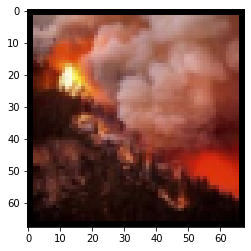

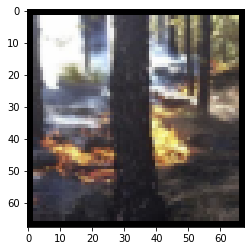

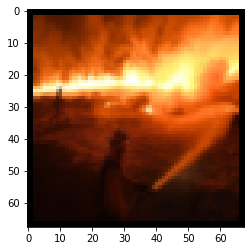

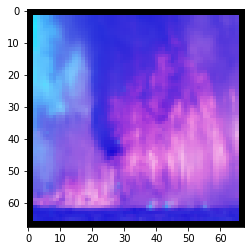

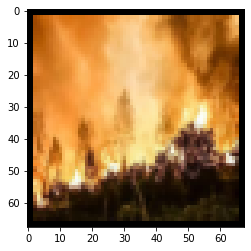

In [9]:
for image in preprocessed_train_fire_images:
    plt.imshow(image)
    plt.show()

In [10]:
# Encoding the labels
train_fire_labels = [0 for i in range(len(train_fire_images))]
train_smoke_labels = [1 for i in range(len(train_smoke_images))]
train_nofire_nosmoke_labels = [2 for i in range(len(train_nofire_nosmoke_images))]

# One-hot encoding the labels using keras library
train_fire_labels = tf.keras.utils.to_categorical(train_fire_labels, num_classes=3)
train_smoke_labels =  tf.keras.utils.to_categorical(train_smoke_labels, num_classes=3)
train_nofire_nosmoke_labels =  tf.keras.utils.to_categorical(train_nofire_nosmoke_labels, num_classes=3)

In [11]:
train_smoke_labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [12]:
# Combining the preprocessed images and their labels
X_train = np.concatenate([preprocessed_train_fire_images, preprocessed_train_smoke_images, preprocessed_train_nofire_nosmoke_images])
y_train = np.concatenate([train_fire_labels, train_smoke_labels, train_nofire_nosmoke_labels])

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (12, 68, 68, 3)
Train labels shape:  (12, 3) float32
Test data shape:  (3, 68, 68, 3)
Test labels shape:  (3, 3)


In [14]:
mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
X_train = (X_train - mean_pixel) / std_pixel
X_test = (X_test - mean_pixel) / std_pixel

In [15]:
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (12, 68, 68, 3)
Train labels shape:  (12, 3) float32
Test data shape:  (3, 68, 68, 3)
Test labels shape:  (3, 3)


Label all images in the train folders

## Model Creation

In [16]:
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

In [17]:
base_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[68,68,3]),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])

In [18]:
base_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
history_base = base_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
1/1 [==============================] - 0s 308ms/step - loss: 1.0935 - accuracy: 0.2500 - val_loss: 1.5376 - val_accuracy: 0.3333
Epoch 2/10
1/1 [==============================] - 0s 32ms/step - loss: 1.0212 - accuracy: 0.6667 - val_loss: 0.8240 - val_accuracy: 0.6667
Epoch 3/10
1/1 [==============================] - 0s 41ms/step - loss: 0.8878 - accuracy: 0.6667 - val_loss: 0.4083 - val_accuracy: 0.6667
Epoch 4/10
1/1 [==============================] - 0s 38ms/step - loss: 0.4886 - accuracy: 0.5833 - val_loss: 0.0451 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 32ms/step - loss: 0.0380 - accuracy: 1.0000 - val_loss: 0.0802 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 29ms/step - loss: 0.1262 - accuracy: 0.9167 - val_loss: 0.1171 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 29ms/step - loss: 0.1420 - accuracy: 0.9167 - val_loss: 0.0769 - val_accuracy: 1.0000
Epoch 8/10
1/1 [==========

## Model Performance Analysis

In [19]:
class_names = ['fire', 'smoke', 'no_fire_no_smoke']

In [20]:
predicted_classes  = np.argmax(base_model.predict(X_test.reshape(-1,68,68,3)), axis=-1)
y_true=y_test

In [21]:
y_true = np.argmax(y_test, axis=-1)
correct = np.nonzero(predicted_classes == y_true)[0]
incorrect = np.nonzero(predicted_classes != y_true)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 3
Incorrect predicted classes: 0


## Predicting images from computer camera imagery

In [22]:
frame_folder = "/Users/koray/Downloads/Artefact/main_dataset/camera_snapshots"
os.mkdir(frame_folder)

In [24]:
# We want to find out the frames per second in order to set a capture for the number of frames we want in a particular length of time
framecap = cv2.VideoCapture(0)
fps = framecap.get(cv2.CAP_PROP_FPS)
print(fps, 'fps')

30.0 fps


In [25]:
frame_count = 0
frame, img = framecap.read()

while frame == True:
    frame, img = framecap.read()
    print('Frame has been saved...', frame)
    
    if not frame:
        print('Frame save has been saved...', frame)
        break
        
    cv2.imwrite(os.path.join(frame_folder, "Computer Frame Image {:d}.jpg".format(frame_count)), img)
    
    # This can be changed to give a different frame number saved, e.g. 10 = every 10th frame
    num_frame = 10
    frame_count = frame_count + num_frame
    
    # This number can be changed dependent on how many frame captures you want saved, e.g. 50 = up to a total of 50 frames
    if frame_count == 50:
        break

Frame has been saved... True
Frame has been saved... True
Frame has been saved... True
Frame has been saved... True
Frame has been saved... True


## Pre-processing captured camera images

In [26]:
def select_images_in_folder(folder):
    all_images = os.listdir(folder)
    return all_images

In [30]:
test_capture_images = select_images_in_folder("/Users/koray/Downloads/Artefact/main_dataset/camera_snapshots")

In [31]:
test_capture_images

['Computer Frame Image 0.jpg',
 'Computer Frame Image 10.jpg',
 'Computer Frame Image 20.jpg',
 'Computer Frame Image 30.jpg',
 'Computer Frame Image 40.jpg']

In [32]:
preprocessed_capture_images = preprocess_images(test_capture_images, "/Users/koray/Downloads/Artefact/main_dataset/camera_snapshots")

## Predicting the capture images using the trained CNN model

In [33]:
predicted_labels = []
for image in preprocessed_capture_images:
    prediction = base_model.predict(np.expand_dims(image, axis=0))[0]
    predicted_label = np.argmax(prediction)
    predicted_labels.append(predicted_label)

In [37]:
label_strings = ['Fire', 'Smoke', 'No Fire/Smoke']
predicted_label_strings = [label_strings[label] for label in predicted_labels]

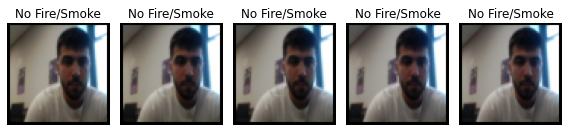

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=len(preprocessed_capture_images), figsize=(8, 8))

for i, ax in enumerate(axes):
    ax.imshow(preprocessed_capture_images[i])
    ax.set_title(predicted_label_strings[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

## Plotting the train and test imagery

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


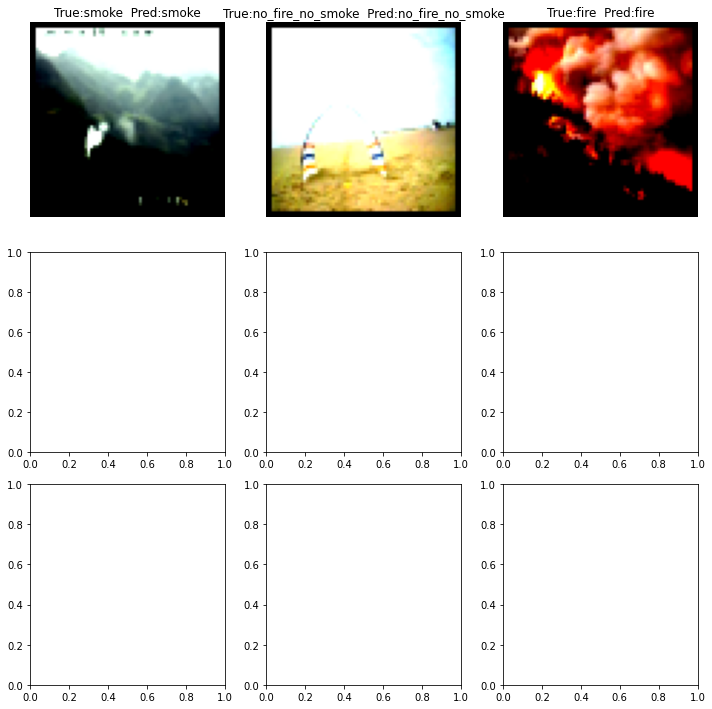

In [43]:
def plot_images(data_index):
    f, ax = plt.subplots(3, 3, figsize=(10,10))

    for i, indx in enumerate(data_index[:9]):
        ax[i//3, i%3].imshow(X_test[indx].reshape(68, 68, 3), cmap='gray')
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title("True:{}  Pred:{}".format(class_names[y_true[indx]], class_names[predicted_classes[indx]]))
    f.tight_layout()
    plt.show()   

plot_images(correct)

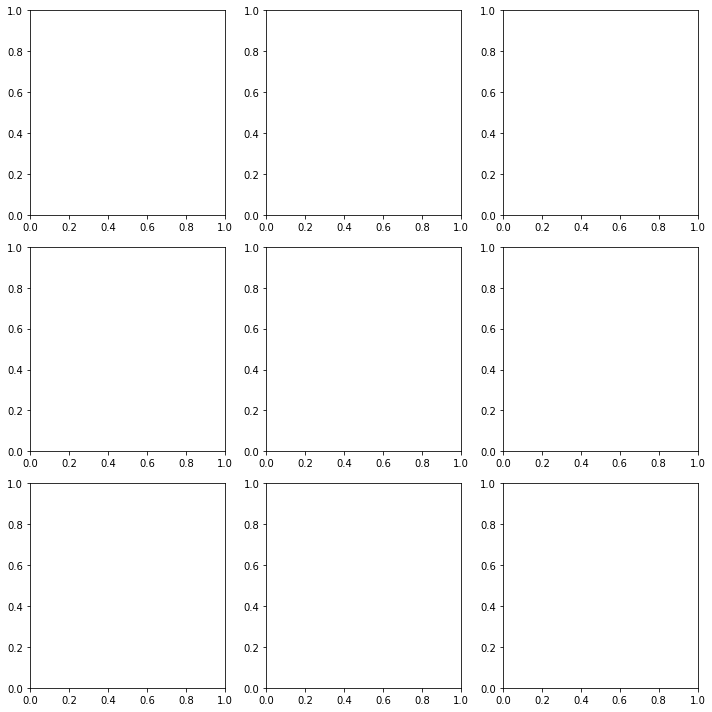

In [44]:
plot_images(incorrect)